Time difference of 0.1561298 secs

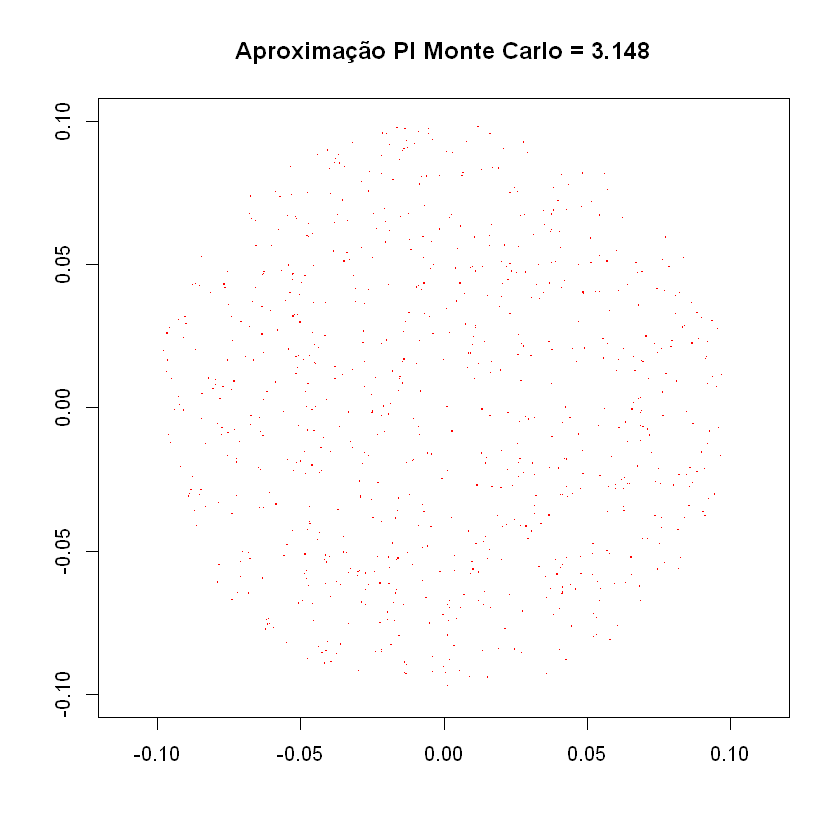

In [1]:
#Simulação de PI
start <- Sys.time()
sim_pi <- function(n_sim, minimo, maximo){
  if(minimo >= 0){
    stop(message("Minimum value must be lower than 0"))
  }
  if(!is.integer(n_sim)){
    stop(message("Number of simulations must be integer"))
  }
  if(maximo != -minimo){
    stop("Maximum value must be the opposite of the minimum value")
  }
  x <- runif(n_sim, minimo, maximo)
  y <- runif(n_sim, minimo, maximo)
  dentro_circulo <- x^2 + y^2 <= maximo^2
  pi_monte_carlo <- (sum(dentro_circulo)/n_sim)*4
  plot(x,y,pch='.',col=ifelse(dentro_circulo,"red","white")
       ,xlab='', ylab='',asp=1,
       main=paste("Aproximação PI Monte Carlo =", pi_monte_carlo))
}
sim_pi(n_sim = 1000L, minimo = -0.1, maximo = 0.1)
end <- Sys.time()
end - start

In [1]:
options(warn = -1)
suppressPackageStartupMessages({library(stats)
library(ggplot2)
library(dplyr)
library(tidyr)
library(bizdays)
library(timeDate)})

In [2]:
#Retorno esperado, desvio-padrão e período de 1 ano útil
u <- 0.6624935
sd <- 0.3874036
periodo <- 252
u_d <- u/(periodo-1)
sd_d <- sd/sqrt(periodo-1)

In [3]:
#Dados da simulação
n_sim <- 7000
total_sim <- matrix(0, nrow = periodo, ncol = n_sim)
p_inicial <- 100

## Simulando a carteira
$$P_{i} = P_{i-1}+P_{i-1}(u_d + \sigma_d * i)$$
Onde $P_i$ é o preço atual, $u_d$ é o retorno diário esperado, $\sigma$ é a volatilidade diária (ou a volatilidade anual dividida por
$\sqrt252$), e $i$ é uma variável dentro de uma distribuição normal média 0 e $\sigma = 1$

In [4]:
total_sim[1,] <- p_inicial
total_sim[2:nrow(total_sim),] <- total_sim[2:nrow(total_sim),] %>%
  apply(2,rnorm, sd = sd_d, mean = u_d)
total_sim[2:nrow(total_sim),] <- apply(total_sim[2:nrow(total_sim),]+1,2,cumprod)
total_sim[2:nrow(total_sim),] <- total_sim[2:nrow(total_sim),]*p_inicial

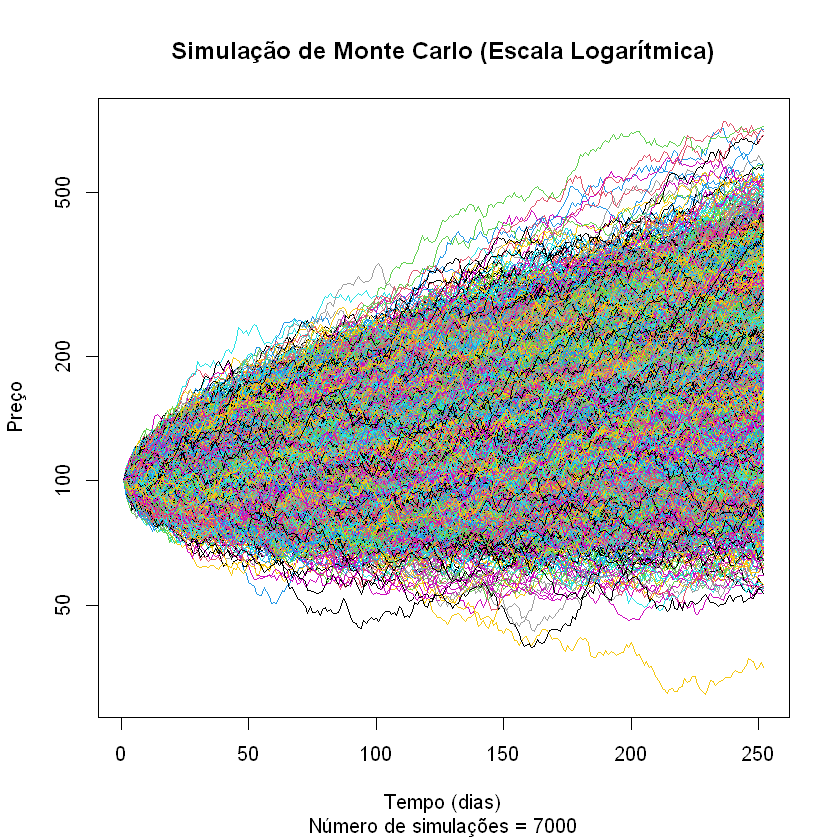

In [5]:
matplot(total_sim,
        main="Simulação de Monte Carlo (Escala Logarítmica)",
        xlab="Tempo (dias)",ylab="Preço",
        col=1:n_sim, type = "l", sub = paste("Número de simulações =",n_sim),
        lty = 1,
        log = "y",
        cex = 0.4)

In [6]:
#5% dos preços são menores que X e 95% são menores que Y
total_sim %>% quantile(probs = c(0.05,0.95)) %>% round(2) %>% print

    5%    95% 
 86.75 243.77 


In [7]:
p_5 <- qnorm(0.05)
p_1 <- qnorm(0.01)

## Value at Risk
O Value at Risk (ou VaR) pode ser calculado por $|R - Z\sigma|$ ou por $1- e^{Z\sigma+R}$, onde $R$ é o retorno esperado do período, $\sigma$ o desvio-padrão do período e $Z$ é o valor do nível de significância. Utilizei a segunda fórmula por mais se adequar

In [8]:
#VaR Paramétrico diário
Ug <- (1+u)^(1/(periodo-1))-1
sd_d <- sd/sqrt((periodo-1))
VaR5 <- round((1-exp(p_5*sd_d+Ug))*100,3)
names(VaR5) <- "VaR diário em % com 5% chance"
VaR5
VaR1 <- round((1-exp(p_1*sd_d+Ug))*100,3)
names(VaR1) <- "VaR diário em % com 1% de chance"
VaR1

VaR diário em % com 5% chance 
                        3.747

VaR diário em % com 1% de chance 
                           5.338

In [9]:
#VaR não paramétrico diário
retorno_d <- diff(total_sim,1)/total_sim[1:(nrow(total_sim)-1),]
var5 <- -round(quantile(retorno_d*100, probs = c(0.05)),3)
names(var5) <- c("VaR 5% chance em %")
var5
var1 <- -round(quantile(retorno_d*100, probs = 0.01),3)
names(var1) <- "VaR 1% chance em %"
var1

VaR 5% chance em % 
             3.756

VaR 1% chance em % 
             5.433

In [10]:
d <- retorno_d %>%
  as.data.frame() %>%
  gather()

In [11]:
#VaR modificado
s <- skewness(d$value)[1]
k <- kurtosis(d$value)[1]
m_var5 <- var5/100+((p_5^2-1)*s/6)+((p_5^3-3*p_5)*k/24)-((2*p_5^3-5*p_5)*s^2/36)
names(m_var5) <- "VaR Modificada 5%"
m_var5 <- round(m_var5*100,3)
m_var5
m_var1 <- var1/100+((p_1^2-1)*s/6)+((p_1^3-3*p_1)*k/24)-((2*p_1^3-5*p_1)*s^2/36)
names(m_var1) <- "VaR Modificada 1%"
m_var1 <- round(m_var1*100,3)
m_var1

VaR Modificada 5% 
             3.75

VaR Modificada 1% 
            5.472

In [12]:
#VaR Paramétrico Mensal
Ug_m <- (1+u)^(1/(12*(periodo/252)))-1
sd_m <- sd/sqrt(12*periodo/252)
VaR5_m <- round((1-exp(p_5*sd_m+Ug_m))*100,3)
names(VaR5_m) <- "VaR mensal em % com 5% chance"
VaR5_m
VaR1_m <- round((1-exp(p_1*sd_m+Ug_m))*100,3)
names(VaR1_m) <- "VaR mensal em % com 1% de chance"
VaR1_m

VaR mensal em % com 5% chance 
                       13.123

VaR mensal em % com 1% de chance 
                          19.499

In [13]:
#VaR Não-Paramétrico Mensal
retorno_m <- diff(total_sim,21)/total_sim[1:(nrow(total_sim)-21),]
var5_m <- -round(quantile(retorno_m*100, probs = c(0.05)),3)
names(var5_m) <- "VaR mensal 5% chance em %"
var1_m <- -round(quantile(retorno_m*100, probs = c(0.01)),3)
names(var1_m) <- "VaR mensal 1% chance em %"
var5_m
var1_m

VaR mensal 5% chance em % 
                     12.7

VaR mensal 1% chance em % 
                   19.225

In [14]:
estatisticas <- round(c(mean(total_sim[periodo,]), min(total_sim),
                  max(total_sim), 100*(quantile(total_sim[periodo,], probs = 0.5)/p_inicial)-100),2)
names(estatisticas) <- c("Média final", "Mínimo", "Máximo", "Retorno mediano em %")
print(estatisticas)

         Média final               Mínimo               Máximo 
              193.45                30.41               741.44 
Retorno mediano em % 
               79.24 


In [15]:
fora_curva <- round(c(((min(total_sim)/p_inicial)-1)*100,
                      ((max(total_sim)/p_inicial)-1)*100),3)
names(fora_curva) <- c("Perda Máxima %", "Ganho Máximo %")
print(fora_curva)

Perda Máxima % Ganho Máximo % 
       -69.586        641.439 


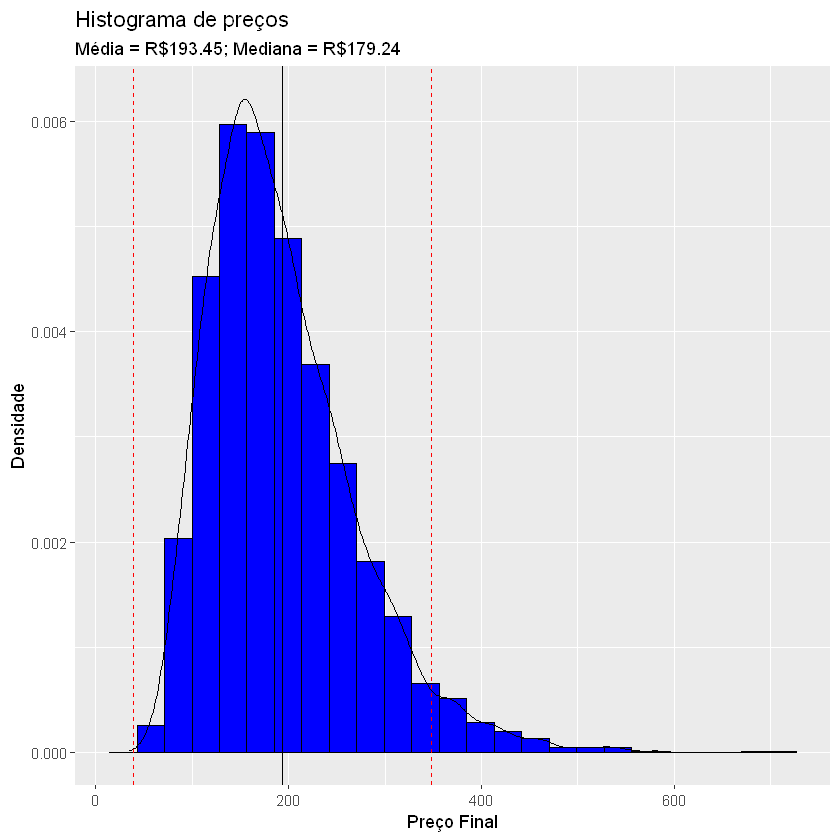

In [16]:
data <- data.frame(Final = total_sim[nrow(total_sim),])
ggplot(data, aes(x = Final, after_stat(density)))+
  geom_histogram(fill = "blue", col = "black", bins = 25)+
  geom_density()+
  geom_vline(xintercept = c(mean(data$Final),
                            mean(data$Final)+2*sd(data$Final),
                            mean(data$Final)-2*sd(data$Final)),
             col = c("black", "red", "red"), lty = c(1,2,2))+
  labs(x = "Preço Final", y = "Densidade", title = "Histograma de preços",
       subtitle = paste0("Média = R$",round(mean(data$Final),2),
                         "; Mediana = R$",round(median(data$Final),2)))

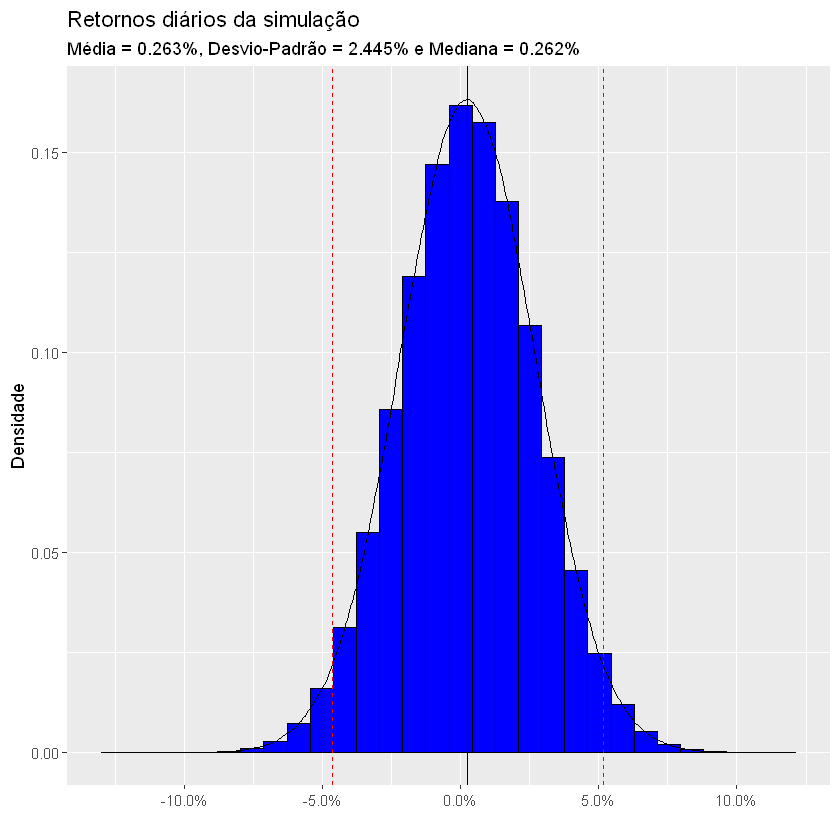

In [17]:
#Histograma de retornos diários
retorno <- retorno_d %>%
  data.frame() %>%
  gather(key = "Simulacoes", value = "value")
bandas <- c(mean(retorno$value),
            mean(retorno$value)+2*sd(retorno$value),
            mean(retorno$value)-2*sd(retorno$value))
retorno %>%
  ggplot(aes(x = value, after_stat(density)/100))+
  geom_histogram(fill = "blue", col = "black", bins = 30)+
  geom_density()+
  labs(x = "", y = "Densidade",
       title = "Retornos diários da simulação",
       subtitle = paste0("Média = ",round(mean(retorno$value)*100,3),"%, Desvio-Padrão = ",
                         round(sd(retorno$value)*100,3),
                         "% e Mediana = ",round(median(retorno$value)*100,3),"%"))+
  geom_vline(xintercept = bandas, lty = c(1,2,2), col = c("black", "red", "red"))+
  scale_x_continuous(labels = scales::percent)

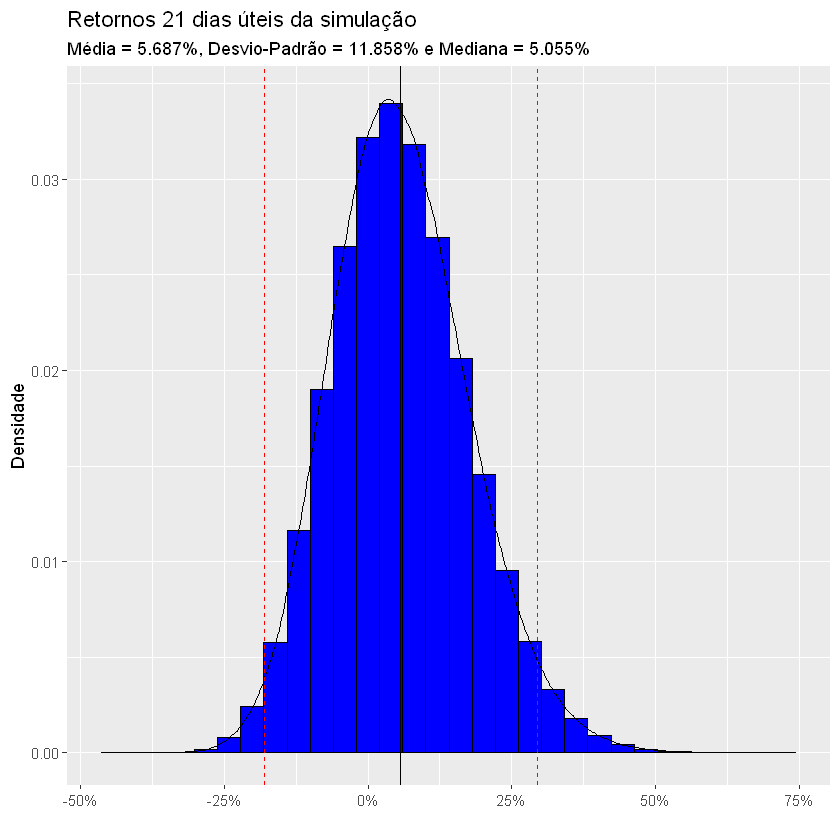

In [18]:
#Histograma de retornos mensais (21 dias úteis)
var_m <- retorno_m %>%
  data.frame() %>%
  gather(key = "Simulacoes", value = "value")
bandas_m<- c(mean(var_m$value),
            mean(var_m$value)+2*sd(var_m$value),
            mean(var_m$value)-2*sd(var_m$value))
var_m %>%
  ggplot(aes(x = value, after_stat(density)/100))+
  geom_histogram(fill = "blue", col = "black", bins = 30)+
  geom_density()+
  labs(x = "", y = "Densidade",
       title = "Retornos 21 dias úteis da simulação",
       subtitle = paste0("Média = ",round(mean(var_m$value)*100,3),"%, Desvio-Padrão = ",
                         round(sd(var_m$value)*100,3),
                         "% e Mediana = ", round(median(var_m$value)*100,3),"%"))+
  geom_vline(xintercept = bandas_m, lty = c(1,2,2), col = c("black", "red", "red"))+
  scale_x_continuous(labels = scales::percent)

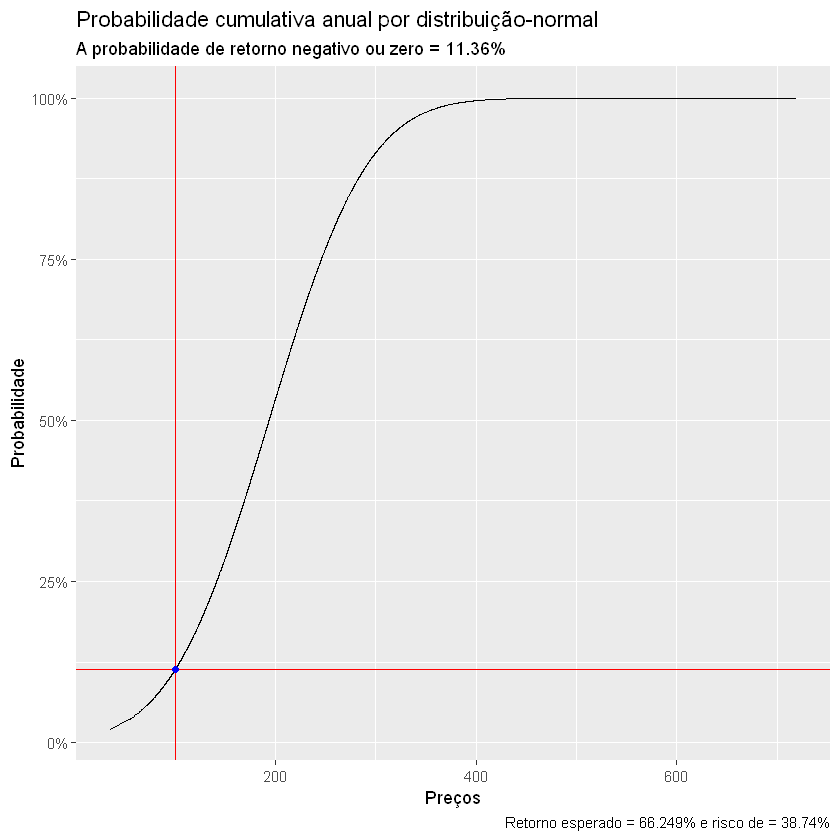

In [19]:
#Probabilidade anual pela distribuição normal
prob1 <- pnorm(data$Final, mean = mean(data$Final), sd = sd(data$Final))
prob1 <- data.frame(Preços = sort(data$Final), Probabilidade = sort(prob1))
pre <- pnorm(p_inicial, mean = mean(prob1$Preços), sd = sd(prob1$Preços))
ggplot(prob1, aes(x = Preços, y = Probabilidade))+
  geom_line()+
  geom_hline(yintercept = pre, col = "red")+
  geom_vline(xintercept = p_inicial, col = "red")+
  labs(title = "Probabilidade cumulativa anual por distribuição-normal",
       subtitle = paste0("A probabilidade de retorno negativo ou zero = ",round(pre*100,2),"%"),
      caption = paste0("Retorno esperado = ",round(u*100,3),"% e risco de = ",round(sd*100,3),"%"))+
  geom_point(aes(x = p_inicial, y = pre), col = "blue")+
  scale_y_continuous(labels = scales::percent)

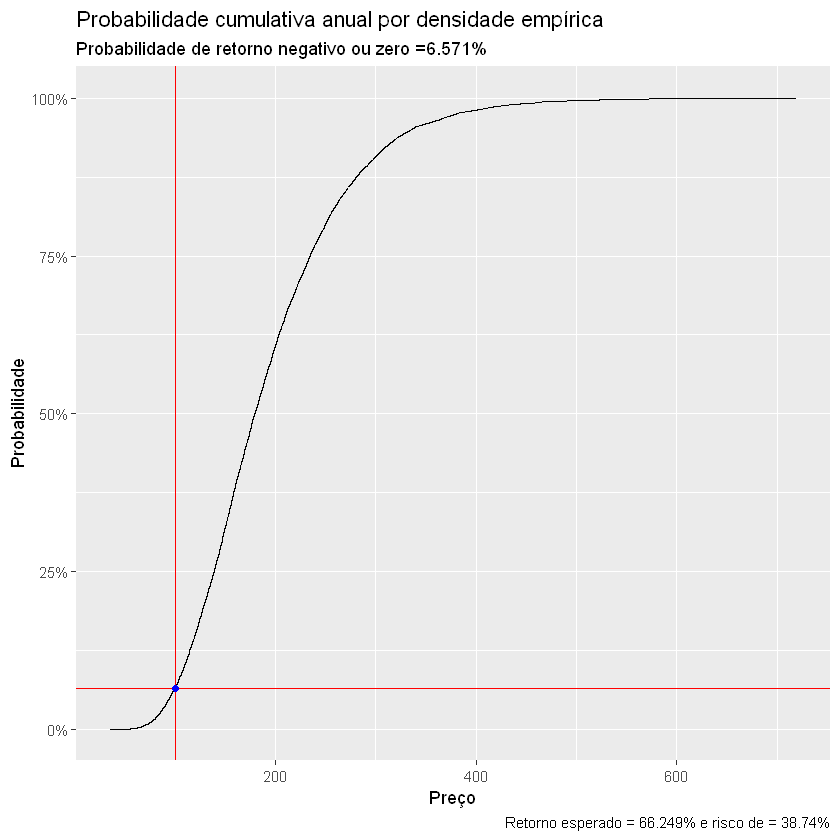

In [20]:
#Probabilidade anual pela soma cumulativa da densidade empírica
prob2 <- cumsum(table(data$Final)/n_sim)
prob2 <- data.frame(Preco = sort(data$Final), Prob = prob2)
val <- first(prob2$Prob[which(prob2$Preco >= p_inicial & prob2$Preco < p_inicial*1.01)])
ggplot(prob2,aes(x = Preco, y = Prob))+
  geom_line()+
  geom_hline(yintercept = val, col = "red")+
  geom_vline(xintercept = p_inicial, col = "red")+
  geom_point(aes(x = p_inicial,
                 y = val),
             col = "blue")+
  labs(subtitle = paste0("Probabilidade de retorno negativo ou zero =",
                         round(val*100,3),"%"),
       x = "Preço", y = "Probabilidade",
       title = "Probabilidade cumulativa anual por densidade empírica",
      caption = paste0("Retorno esperado = ",round(u*100,3),"% e risco de = ",round(sd*100,3),"%"))+
  scale_y_continuous(labels = scales::percent)

In [21]:
calendario <- bizdays::create.calendar(name = "ANBIMA",
                                       holidays = bizdays::holidaysANBIMA,
                                       weekdays = c("saturday", "sunday"),
                                       start.date = Sys.Date())

`summarise()` ungrouping output (override with `.groups` argument)



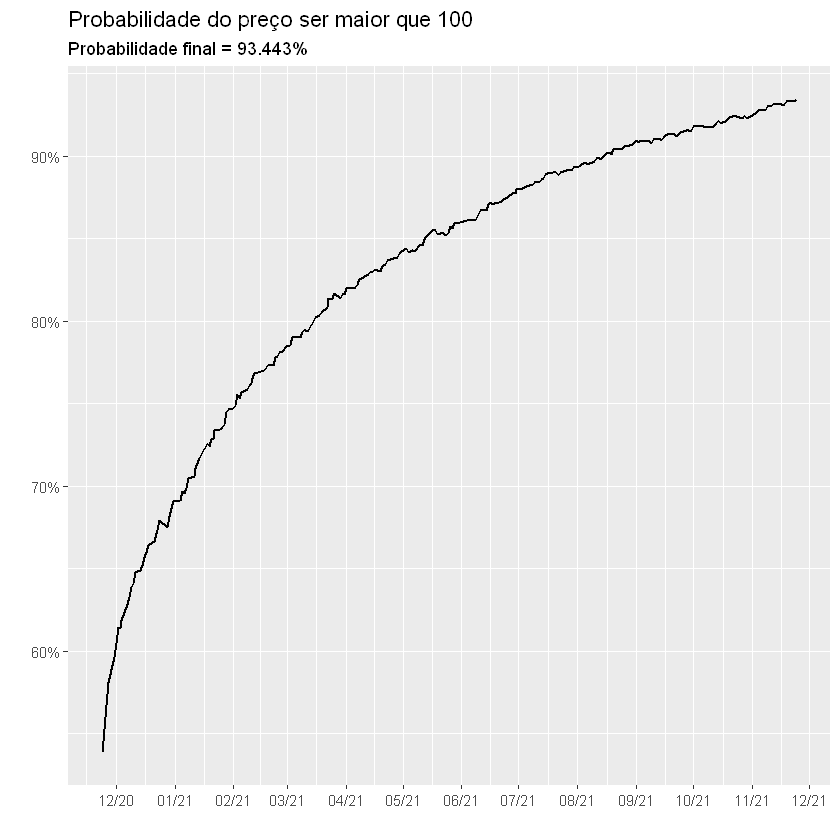

In [22]:
#Probabilidade do preço ser maior que o preço inicial
total_df <- total_sim %>% as.data.frame()
total_df <- total_df %>%
  mutate(periodo = bizdays::add.bizdays(Sys.Date(), 1:periodo, "ANBIMA")) %>%
  gather(key = "simulacoes", value = "preco", -periodo)
meta <- p_inicial
prob <- total_df %>%
  group_by(periodo) %>%
  summarise(prob = mean(preco > meta))
ggplot(prob[which(prob$prob != 0),], aes(x = periodo, y = prob))+
  geom_line(size = 0.7)+
  labs(x = "", y = "", title = paste("Probabilidade do preço ser maior que",round(meta,2)),
       subtitle = paste0("Probabilidade final = ", round(last(prob$prob)*100,3), "%"))+
  scale_y_continuous(labels = scales::percent)+
  scale_x_date(date_labels = "%m/%y",date_breaks = "1 month")

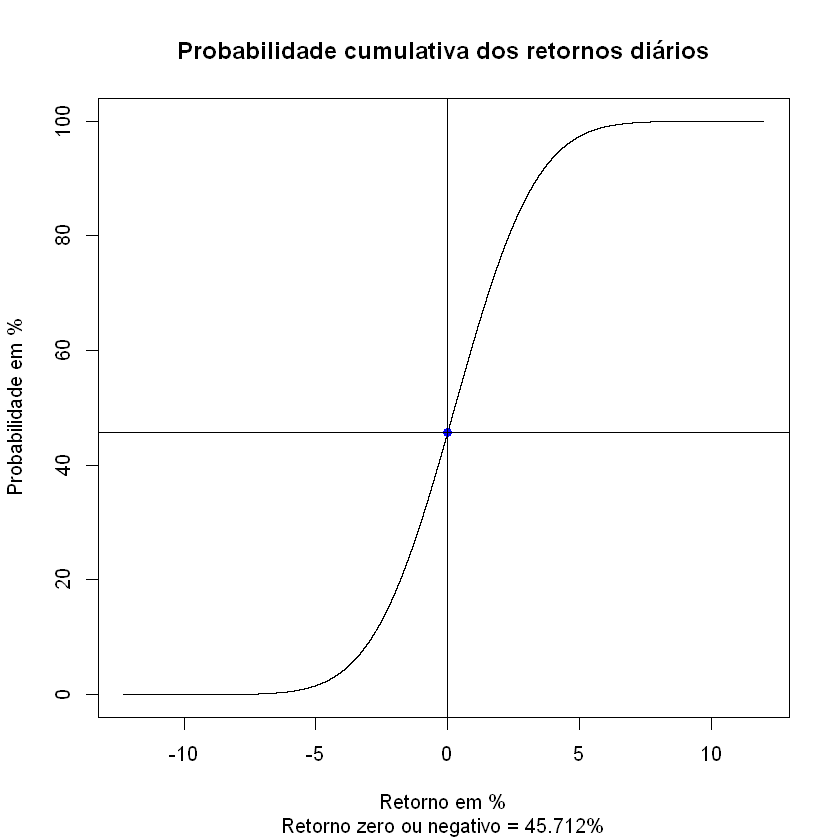

In [23]:
#Probabilidade diária por distribuição-normal
reto_d <- retorno_d %>%
  as.data.frame %>%
  gather(key = "Retornos", value = "value") %>%
  summarise(Ret = sort(value))
perc_d <- pnorm(reto_d$Ret, mean = mean(reto_d$Ret), sd = sd(reto_d$Ret))
var_d <- data.frame(Retorno = reto_d$Ret, Percent = perc_d)
ret_z <- pnorm(0,mean = mean(reto_d$Ret), sd = sd(reto_d$Ret))
plot(var_d$Retorno*100, var_d$Percent*100, type = "l", xlab = "Retorno em %",
     ylab = "Probabilidade em %",
     main = "Probabilidade cumulativa dos retornos diários",
     sub = paste0("Retorno zero ou negativo = ",round(ret_z*100,3),"%"))
points(x = 0, y = ret_z*100, pch = 16, col = "blue", cex = 1)
abline(h = ret_z*100, v = 0)

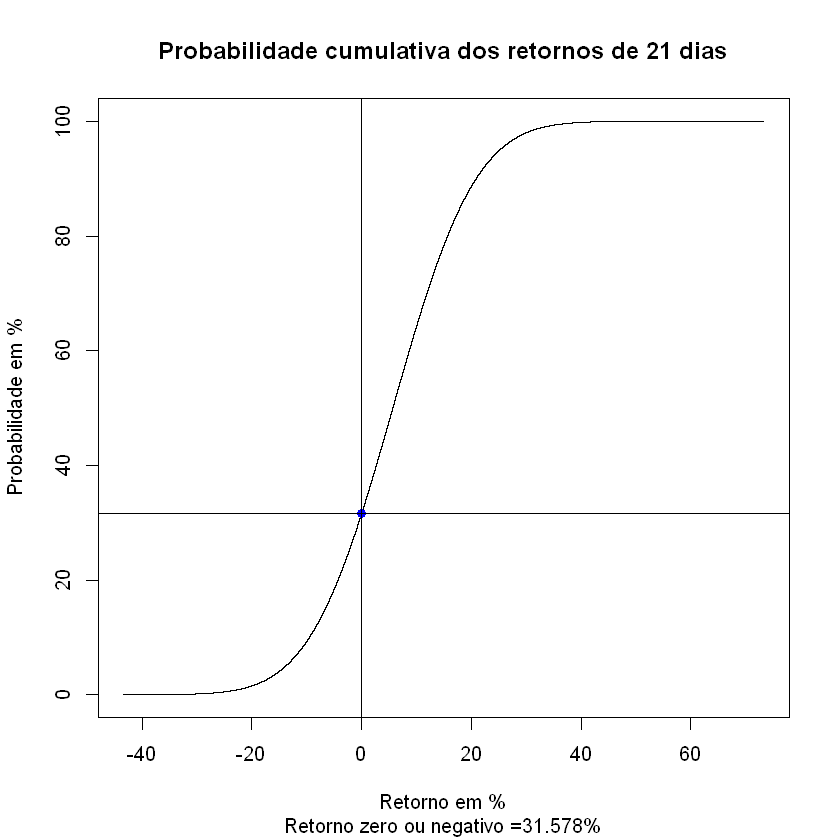

In [24]:
#Probabilidade mensal por distribuição-normal
reto_m <- retorno_m %>%
  as.data.frame %>%
  gather(key = "Retornos", value = "value") %>%
  summarise(Ret = sort(value))
perc_m <- pnorm(reto_m$Ret, mean = mean(reto_m$Ret), sd = sd(reto_m$Ret))
var_m <- data.frame(Retorno = sort(reto_m$Ret), Percent = perc_m)
ret_m <- pnorm(0,mean = mean(reto_m$Ret), sd = sd(reto_m$Ret))
plot(var_m$Retorno*100, var_m$Percent*100, type = "l", xlab = "Retorno em %",
     ylab = "Probabilidade em %",
     main = "Probabilidade cumulativa dos retornos de 21 dias",
     sub = paste0("Retorno zero ou negativo =",round(ret_m*100,3),"%"))
points(x = 0, y = ret_m*100, pch = 16, col = "blue", cex = 1)
abline(h = ret_m*100, v = 0)

`summarise()` ungrouping output (override with `.groups` argument)



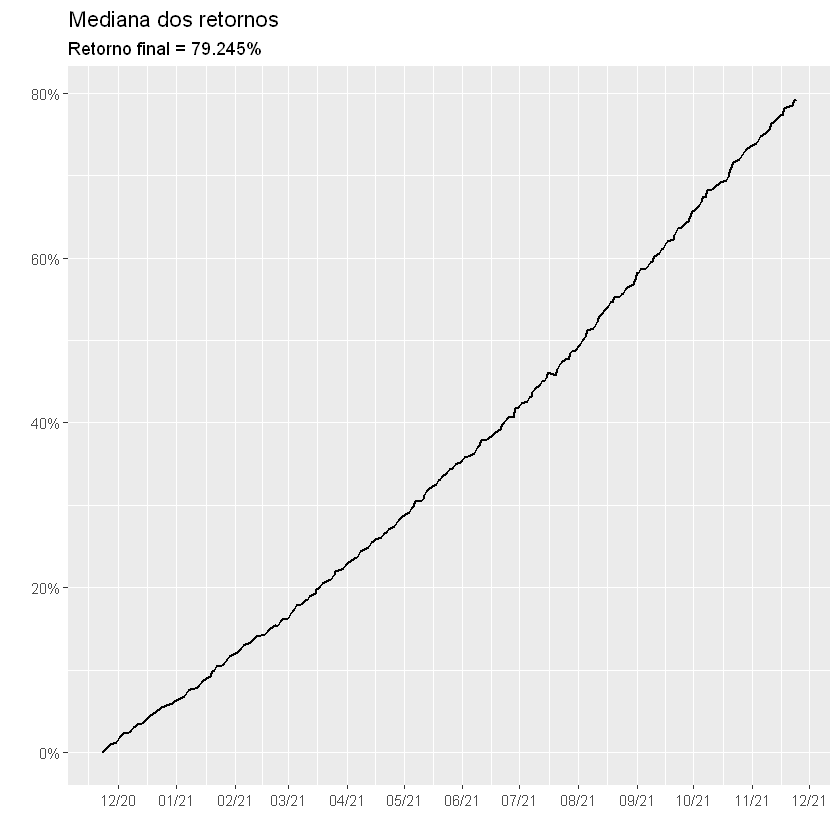

In [25]:
mediana <- total_df %>%
  group_by(periodo) %>%
  summarise(mediana = (median(preco)-p_inicial)/p_inicial)
ggplot(mediana, aes(x = periodo, y = mediana))+
  geom_line(size = 0.7)+
  labs(x = "", y = "", title = "Mediana dos retornos",
       subtitle = paste0("Retorno final = ", round(last(mediana$mediana)*100,3), "%"))+
  scale_y_continuous(labels = scales::percent)+
  scale_x_date(date_labels = "%m/%y",date_breaks = "1 month")